**Assignment**

Design and implement a convolutional neural network (CNN) architecture utilizing four dense blocks. The convolution operations should be performed using depth-wise separable convolutions. Train the CNN on the CIFAR-10 dataset and evaluate its performance in terms of classification accuracy, precision, recall, and F1 score. Additionally, compare the computational efficiency and effectiveness of depth-wise and point-wise convolutions against traditional convolutional layers. Ensure the model is trained for at least 100 epochs or until the loss curve stabilizes.

**Import Libraries**

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models, datasets
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

**Loading the Dataset**

In [4]:

# Load CIFAR-10 dataset using tensorflow.keras.datasets
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# One-hot encode labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step


In [6]:
def depthwise_separable_conv(x, filters, kernel_size, strides=(1, 1)):
    # Depth-wise convolution
    x = layers.DepthwiseConv2D(kernel_size, strides=strides, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Point-wise convolution
    x = layers.Conv2D(filters, (1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

In [7]:
def dense_block(x, num_layers, growth_rate):
    for _ in range(num_layers):
        # Apply depth-wise separable convolution
        conv_output = depthwise_separable_conv(x, growth_rate, (3, 3))
        # Concatenate input and output
        x = layers.Concatenate()([x, conv_output])
    return x

**Model Building of Depthwise Seperable Model**

In [8]:
def build_model():
    inputs = layers.Input(shape=(32, 32, 3))

    # Initial convolution
    x = layers.Conv2D(64, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Four dense blocks
    growth_rate = 32
    num_layers_per_block = 4

    for _ in range(4):
        x = dense_block(x, num_layers_per_block, growth_rate)
        # Transition layer (reduce dimensionality)
        x = layers.Conv2D(x.shape[-1] // 2, (1, 1), padding='same')(x)
        x = layers.AveragePooling2D((2, 2))(x)

    # Global average pooling and output layer
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(10, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

model = build_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 64)     │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 32, 32, 64)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ depthwise_conv2d          │ (None, 32, 32, 64)     │            640 │ re_lu[0][0]            │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 64)     │            256 │ depthwise_conv2d[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 32, 32, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 32)     │          2,080 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 32)     │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 32, 32, 32)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 96)     │              0 │ re_lu[0][0],           │
│                           │                        │                │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ depthwise_conv2d_1        │ (None, 32, 32, 96)     │            960 │ concatenate[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 32, 32, 96)     │            384 │ depthwise_conv2d_1[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 32, 32, 96)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 32)     │          3,104 │ re_lu_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 32, 32, 32)     │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization) 

 Total params: 216,838 (847.02 KB)

 Trainable params: 211,014 (824.27 KB)

 Non-trainable params: 5,824 (22.75 KB)

**Training the Depthwise seperable model**

In [9]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train,
                    epochs=100,
                    batch_size=64,
                    validation_data=(x_test, y_test),
                    verbose=1)

Epoch 1/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 98s 68ms/step - accuracy: 0.4830 - loss: 1.4240 - val_accuracy: 0.5424 - val_loss: 1.3736
Epoch 2/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.7320 - loss: 0.7610 - val_accuracy: 0.7413 - val_loss: 0.7430
Epoch 3/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 39ms/step - accuracy: 0.7980 - loss: 0.5841 - val_accuracy: 0.7197 - val_loss: 0.8225
Epoch 4/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.8315 - loss: 0.4879 - val_accuracy: 0.7102 - val_loss: 0.8639
Epoch 5/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - accuracy: 0.8495 - loss: 0.4295 - val_accuracy: 0.7558 - val_loss: 0.7204
Epoch 6/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.8706 - loss: 0.3738 - val_accuracy: 0.7582 - val_loss: 0.7274
Epoch 7/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.8843 - loss: 0.3265 - val_accuracy: 0.7887 - val_loss: 0.6221
Epoch 8/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.8955 - loss: 0

**Evaluate the Traditional CNN Model**

In [10]:
# Evaluate model on test set
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

# Generate predictions
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate classification metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Print classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred))

# Print overall metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8598 - loss: 0.8364

Test Accuracy: 0.8595
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      1000
           1       0.95      0.90      0.92      1000
           2       0.87      0.77      0.82      1000
           3       0.78      0.71      0.74      1000
           4       0.85      0.85      0.85      1000
           5       0.83      0.77      0.80      1000
           6       0.82      0.94      0.88      1000
           7       0.88      0.91      0.89      1000
           8       0.93      0.90      0.91      1000
           9       0.88      0.93      0.90      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

Accuracy: 0.8595
Precision: 0.8599
Recall: 0.8595
F1 Score: 0.8585


**Function to build a  Traditional model**

In [13]:
import time

# Function to build a model using standard convolutions for comparison
def build_traditional_cnn():
    inputs = layers.Input(shape=(32, 32, 3))

    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)

    for _ in range(4):  # 4 blocks like before
        x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.AveragePooling2D((2, 2))(x)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(10, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

**Training and Evalution of the Traditional CNN Model**

In [20]:
# Compile the traditional CNN model
traditional_model = build_traditional_cnn()
traditional_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train traditional CNN
start_time = time.time()
traditional_history = traditional_model.fit(x_train, y_train,
                                            epochs=100,
                                            batch_size=64,
                                            validation_data=(x_test, y_test),
                                            verbose=1)
traditional_time = time.time() - start_time

# Evaluate traditional CNN on test set
traditional_loss, traditional_accuracy = traditional_model.evaluate(x_test, y_test, verbose=1)

# Measure model size
traditional_params = traditional_model.count_params()

print("\nPerformance Comparison:")
print(f"Depthwise CNN Training Time: {depthwise_time:.2f} seconds")
print(f"Traditional CNN Training Time: {traditional_time:.2f} seconds")
print(f"Depthwise CNN Model Size: {depthwise_params} parameters")
print(f"Traditional CNN Model Size: {traditional_params} parameters")
print(f"Depthwise CNN Test Accuracy: {test_accuracy:.4f}")
print(f"Traditional CNN Test Accuracy: {traditional_accuracy:.4f}")


Epoch 1/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.4631 - loss: 1.4823 - val_accuracy: 0.4381 - val_loss: 1.7774
Epoch 2/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.6990 - loss: 0.8551 - val_accuracy: 0.7126 - val_loss: 0.8388
Epoch 3/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.7691 - loss: 0.6611 - val_accuracy: 0.7550 - val_loss: 0.6992
Epoch 4/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8090 - loss: 0.5459 - val_accuracy: 0.7602 - val_loss: 0.7096
Epoch 5/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.8377 - loss: 0.4697 - val_accuracy: 0.7814 - val_loss: 0.6538
Epoch 6/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8626 - loss: 0.3973 - val_accuracy: 0.8004 - val_loss: 0.5931
Epoch 7/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8786 - loss: 0.3515 - val_accuracy: 0.7576 - val_loss: 0.7382
Epoch 8/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.8918 - loss: 0.3083 -

In [16]:
# Measure training time for depth-wise separable CNN
start_time = time.time()
model.fit(x_train, y_train, epochs=10, batch_size=64, verbose=1)  # Run for 10 epochs for fair comparison
depthwise_time = time.time() - start_time

# Measure model size
depthwise_params = model.count_params()

# Train traditional CNN
traditional_model = build_traditional_cnn()
traditional_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

start_time = time.time()
traditional_model.fit(x_train, y_train, epochs=10, batch_size=64, verbose=1)
traditional_time = time.time() - start_time

# Measure model size
traditional_params = traditional_model.count_params()

print("\nPerformance Comparison:")
print(f"Depthwise CNN Training Time: {depthwise_time:.2f} seconds")
print(f"Traditional CNN Training Time: {traditional_time:.2f} seconds")
print(f"Depthwise CNN Model Size: {depthwise_params} parameters")
print(f"Traditional CNN Model Size: {traditional_params} parameters")

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.9899 - loss: 0.0270
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.9918 - loss: 0.0247
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.9912 - loss: 0.0271
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.9872 - loss: 0.0373
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.9922 - loss: 0.0240
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.9909 - loss: 0.0256
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.9896 - loss: 0.0303
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.9889 - loss: 0.0301
Epoch 9/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.9901 - loss: 0.0264
Epoch 10/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.9887 - loss: 0.0322
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.4488 - loss: 1.5057
Epoch 2/10
782/782 ━━━━━━━━━━━━

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np

# Generate predictions for traditional CNN
y_pred_probs_traditional = traditional_model.predict(x_test)
y_pred_traditional = np.argmax(y_pred_probs_traditional, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate classification metrics
traditional_accuracy = accuracy_score(y_true, y_pred_traditional)
traditional_precision = precision_score(y_true, y_pred_traditional, average='macro')
traditional_recall = recall_score(y_true, y_pred_traditional, average='macro')
traditional_f1 = f1_score(y_true, y_pred_traditional, average='macro')

# Print classification report
print("\nTraditional CNN - Classification Report:\n", classification_report(y_true, y_pred_traditional))

# Print overall metrics
print(f"Traditional CNN - Accuracy: {traditional_accuracy:.4f}")
print(f"Traditional CNN - Precision: {traditional_precision:.4f}")
print(f"Traditional CNN - Recall: {traditional_recall:.4f}")
print(f"Traditional CNN - F1 Score: {traditional_f1:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step

Traditional CNN - Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.80      0.83      1000
           1       0.88      0.92      0.90      1000
           2       0.78      0.73      0.75      1000
           3       0.65      0.70      0.68      1000
           4       0.78      0.82      0.80      1000
           5       0.82      0.69      0.75      1000
           6       0.76      0.92      0.83      1000
           7       0.87      0.84      0.85      1000
           8       0.89      0.90      0.89      1000
           9       0.92      0.86      0.89      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000

Traditional CNN - Accuracy: 0.8183
Traditional CNN - Precision: 0.8217
Traditional CNN - Recall: 0.8183
Traditional CNN - F1 Score: 0.8181


**Pefromance comparison of Depthwise Separable CNN and Traditional CNN**

In [23]:
print("\nPerformance Comparison:")
print(f"{'Metric':<30}{'Depthwise Separable CNN':<25}{'Traditional CNN'}")
print(f"{'-'*70}")
print(f"{'Training Time (s)':<30}{depthwise_time:<25.2f}{traditional_time:.2f}")
print(f"{'Total Parameters':<30}{depthwise_params:<25}{traditional_params}")
print(f"{'Test Accuracy':<30}{test_accuracy:<25.4f}{traditional_accuracy:.4f}")
print(f"{'Precision':<30}{precision:<25.4f}{traditional_precision:.4f}")
print(f"{'Recall':<30}{recall:<25.4f}{traditional_recall:.4f}")
print(f"{'F1 Score':<30}{f1:<25.4f}{traditional_f1:.4f}")



Performance Comparison:
Metric                        Depthwise Separable CNN  Traditional CNN
----------------------------------------------------------------------
Training Time (s)             399.19                   881.94
Total Parameters              216838                   151434
Test Accuracy                 0.8595                   0.8183
Precision                     0.8599                   0.8217
Recall                        0.8595                   0.8183
F1 Score                      0.8585                   0.8181


**Compare Model Performance**

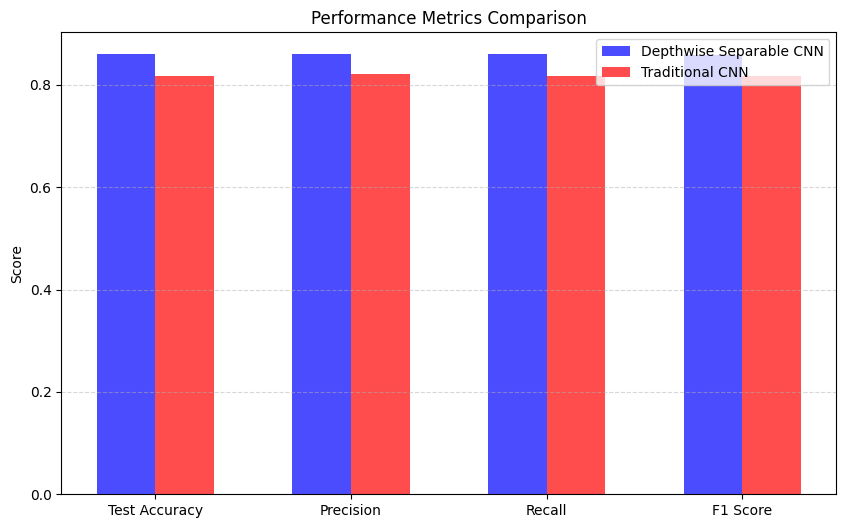

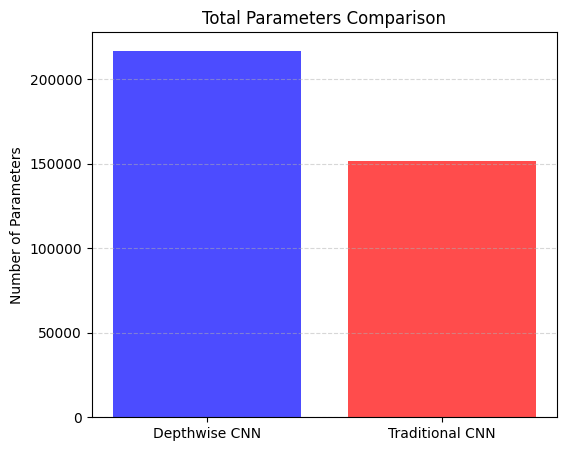

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Define performance metrics and their values
metrics = ["Test Accuracy", "Precision", "Recall", "F1 Score"]
depthwise_values = [test_accuracy, precision, recall, f1]
traditional_values = [traditional_accuracy, traditional_precision, traditional_recall, traditional_f1]

x = np.arange(len(metrics))  # Numeric indices for bars
width = 0.3  # Width of bars


plt.figure(figsize=(10, 6))
plt.bar(x - width/2, depthwise_values, width, color='blue', label="Depthwise Separable CNN", alpha=0.7)
plt.bar(x + width/2, traditional_values, width, color='red', label="Traditional CNN", alpha=0.7)

# Formatting the graph
plt.xticks(x, metrics)
plt.ylabel("Score")
plt.title("Performance Metrics Comparison")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

plt.figure(figsize=(6, 5))
plt.bar(["Depthwise CNN", "Traditional CNN"], [depthwise_params, traditional_params], color=['blue', 'red'], alpha=0.7)

# Formatting the graph
plt.ylabel("Number of Parameters")
plt.title("Total Parameters Comparison")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


**Function to compare Depth-wise Separable vs Traditional Convolution**

In [18]:
# Function to compare Depth-wise Separable vs Traditional Convolution
import time

def compare_convolutions(input_shape=(32, 32, 3), filters=64, kernel_size=(3, 3)):
    inputs = layers.Input(shape=input_shape)

    # Depth-wise separable convolution
    start_time = time.time()
    x = layers.SeparableConv2D(filters, kernel_size, padding='same')(inputs)
    time_depthwise = time.time() - start_time

    # Traditional convolution
    start_time = time.time()
    y = layers.Conv2D(filters, kernel_size, padding='same')(inputs)
    time_traditional = time.time() - start_time

    print(f"\nDepth-wise Convolution Execution Time: {time_depthwise:.6f} seconds")
    print(f"Traditional Convolution Execution Time: {time_traditional:.6f} seconds")

compare_convolutions()


Depth-wise Convolution Execution Time: 0.012176 seconds
Traditional Convolution Execution Time: 0.005685 seconds


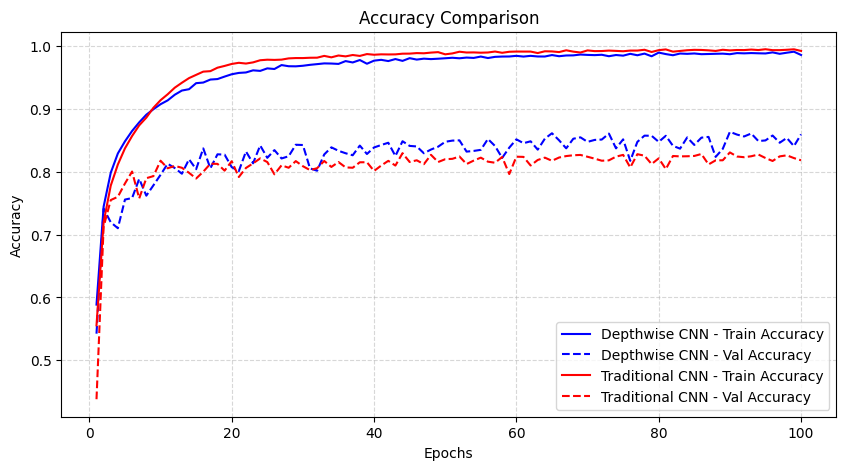

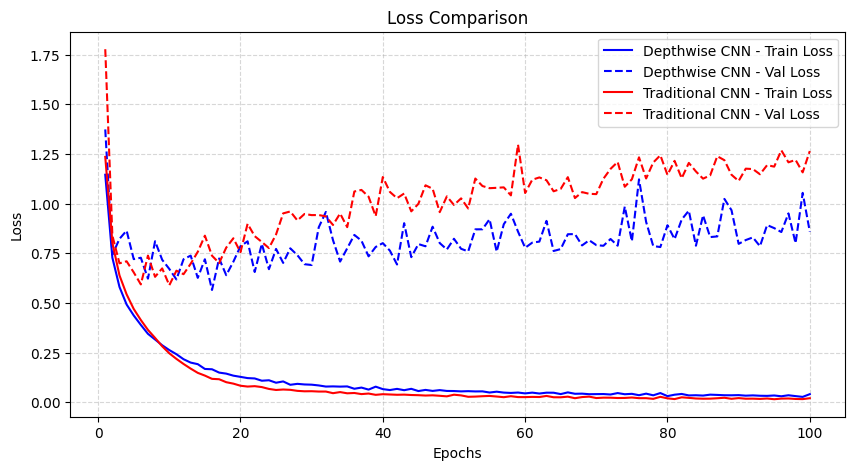

In [32]:
import matplotlib.pyplot as plt

# Extract training history
epochs = range(1, len(history.history['accuracy']) + 1)

#Accuracy Curve
plt.figure(figsize=(10, 5))
plt.plot(epochs, history.history['accuracy'], label="Depthwise CNN - Train Accuracy", color='blue', linestyle='-')
plt.plot(epochs, history.history['val_accuracy'], label="Depthwise CNN - Val Accuracy", color='blue', linestyle='dashed')

plt.plot(epochs, traditional_history.history['accuracy'], label="Traditional CNN - Train Accuracy", color='red', linestyle='-')
plt.plot(epochs, traditional_history.history['val_accuracy'], label="Traditional CNN - Val Accuracy", color='red', linestyle='dashed')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

#  Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(epochs, history.history['loss'], label="Depthwise CNN - Train Loss", color='blue', linestyle='-')
plt.plot(epochs, history.history['val_loss'], label="Depthwise CNN - Val Loss", color='blue', linestyle='dashed')

plt.plot(epochs, traditional_history.history['loss'], label="Traditional CNN - Train Loss", color='red', linestyle='-')
plt.plot(epochs, traditional_history.history['val_loss'], label="Traditional CNN - Val Loss", color='red', linestyle='dashed')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Comparison")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()
